In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import folium
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import re
from windrose import WindroseAxes, plot_windrose
import warnings
warnings.filterwarnings("ignore")
import mitosheet
from plottify import autosize

# plt.rcParams.update({"font.size": 24})


In [2]:
def read_water_gage_station(filename):
    df = pd.read_csv(
        filename,
        index_col="t",
        usecols=lambda column: column not in ["s", "f_x", "g", "f_y", "direction"],
    )
    return df


WaterGageStation8771972 = read_water_gage_station("WaterGageStation8771972.csv")
WaterGageStation8772440 = read_water_gage_station("WaterGageStation8772440.csv")
WaterGageStation8772447 = read_water_gage_station("WaterGageStation8772447.csv")
WaterGageStation8772471 = read_water_gage_station("WaterGageStation8772471.csv")
WaterGageStation8773767 = read_water_gage_station("WaterGageStation8773767.csv")


In [3]:
datasets = {
    "Station 8771972": WaterGageStation8771972,
    "Station 8772440": WaterGageStation8772440,
    "Station 8772447": WaterGageStation8772447,
    "Station 8772471": WaterGageStation8772471,
    "Station 8773767": WaterGageStation8773767,
}


In [4]:
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

rename_columns = {
    "water_level": "Water Level (m)",
    "wind_speed": "Wind Speed (m/s)",
    "wind_direction": "Wind Direction (degrees)",
}


In [5]:
def calculate_sand_flux(wind_speed, threshold):
    Q = 32 # m^2/yr
    if pd.isna(wind_speed) or wind_speed <= threshold:
        return np.nan
    else:
        return Q * ((wind_speed / threshold) ** 2 - 1)

In [6]:
def adjust_wind_direction(df, direction_column ="Wind Direction (degrees)"):
    orientation = 90 - 34
    df["Wind Direction Approaching Island From"] = (df[direction_column] - orientation) % 360
    return df

In [7]:
for dataset_name, df in datasets.items():
    df.rename(columns=rename_columns, inplace=True)
    for col in rename_columns.values():
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df.index = pd.to_datetime(df.index)
    df.insert(0, "Year", df.index.year)
    df.insert(1, "Month", df.index.month)
    # df["Month"] = df["Month"].map(month_map)
    # df["Month"] = pd.Categorical(df["Month"], categories=month_order, ordered=True)
    # df["Year"] = pd.Categorical(df["Year"])
    df = adjust_wind_direction(df, direction_column ="Wind Direction (degrees)")
    datasets[dataset_name] = df



In [8]:
for dataset_name, df in datasets.items():
    df['Flux_Threshold_4'] = df['Wind Speed (m/s)'].apply(calculate_sand_flux, args=(4,))
    df['Flux_Threshold_5'] = df['Wind Speed (m/s)'].apply(calculate_sand_flux, args=(5,))
    df['Sin_Direction_Flux_4'] = np.sin(np.radians(df['Wind Direction Approaching Island From'])) * df['Flux_Threshold_4']
    df['Sin_Direction_Flux_5'] = np.sin(np.radians(df['Wind Direction Approaching Island From'])) * df['Flux_Threshold_5']
    datasets[dataset_name] = df
    average_flux_threshold_4 = round(df['Flux_Threshold_4'].mean(), 2)
    average_flux_threshold_5 = round(df['Flux_Threshold_5'].mean(), 2)
    df_filtered = df[(df['Wind Direction Approaching Island From'] >= 0) & (df['Wind Direction Approaching Island From'] <= 180)]
    average_sin_direction_flux_4 = round(df_filtered['Sin_Direction_Flux_4'].mean(), 2)
    average_sin_direction_flux_5 = round(df_filtered['Sin_Direction_Flux_5'].mean(), 2)
    print(f"{dataset_name}: average_sin_direction_flux_4: {average_sin_direction_flux_4}, average_sin_direction_flux_5: {average_sin_direction_flux_5}")
    print(f"{dataset_name}: average_flux_threshold_4: {average_flux_threshold_4}, average_flux_threshold_5: {average_flux_threshold_5}")
    df.to_csv(os.path.join(base_path, f"{dataset_name}.csv"))
    

Station 8771972: average_sin_direction_flux_4: 22.65, average_sin_direction_flux_5: 13.75
Station 8771972: average_flux_threshold_4: 54.76, average_flux_threshold_5: 38.27
Station 8772440: average_sin_direction_flux_4: 27.67, average_sin_direction_flux_5: 16.97
Station 8772440: average_flux_threshold_4: 44.04, average_flux_threshold_5: 28.1
Station 8772447: average_sin_direction_flux_4: 29.02, average_sin_direction_flux_5: 18.07
Station 8772447: average_flux_threshold_4: 38.95, average_flux_threshold_5: 24.25
Station 8772471: average_sin_direction_flux_4: 39.7, average_sin_direction_flux_5: 24.02
Station 8772471: average_flux_threshold_4: 60.69, average_flux_threshold_5: 38.16
Station 8773767: average_sin_direction_flux_4: 43.32, average_sin_direction_flux_5: 26.05
Station 8773767: average_flux_threshold_4: 73.51, average_flux_threshold_5: 46.21


In [9]:
def remove_rows_with_missing_values(df, column1, column2=None):
    columns_to_check = [column1]
    if column2:
        columns_to_check.append(column2)
    return df.dropna(subset=columns_to_check)

In [10]:
def plot_windrose_subplots(data, *, direction, var, color=None, **kwargs):
    """wrapper function to create subplots per axis"""
    ax = plt.gca()
    ax = WindroseAxes.from_ax(ax=ax)
    plot_windrose(direction_or_df=data[direction], var=data[var], ax=ax, **kwargs)

In [11]:
def plot_windrose_facetgrid(df, 
                            direction_column='wind_direction', magnitude_column='wind_speed',
                            base_path=None,
                            subfolder=None,
                            title=None):
    
    df = remove_rows_with_missing_values(df, direction_column, magnitude_column)
    df.loc[:, "Year"] = df.index.year
    df.loc[:, "Month"] = df.index.month
    if base_path and subfolder:
        full_path = os.path.join(base_path, subfolder)
        os.makedirs(full_path, exist_ok=True)
    else:
        full_path = base_path

    g = sns.FacetGrid(
        data=df,
        col="Year",
        col_wrap=3,
        subplot_kws={"projection": "windrose"},
        sharex=False,
        sharey=False,
        despine=False,
        height=3.5,
    )

    if magnitude_column == 'Wind Speed (m/s)':
        bins = (0.1, 1, 2, 3, 4, 5)
    elif magnitude_column in ['Flux_Threshold_4', 'Flux_Threshold_5']:
        bins = (0, 15, 30, 70, 100)
        pass

    
    g.map_dataframe(
        plot_windrose_subplots,
        direction=direction_column,
        var=magnitude_column,
        normed=True,
        bins=bins,
        calm_limit=0.1,
        kind="bar",
    )

    y_ticks = range(0, 17, 4)
    if magnitude_column == 'Wind Speed (m/s)':
        legend_title = "$m \cdot s^{-1}$"
    elif magnitude_column in ['Flux_Threshold_4', 'Flux_Threshold_5']:
        legend_title = "$m^2 \cdot yr^{-1}$"
    for ax in g.axes:
        ax.set_legend(
            title=legend_title, 
            bbox_to_anchor=(1.15, -0.1), 
            loc="lower right"
        )
        ax.set_rgrids(y_ticks, y_ticks)

    plt.subplots_adjust(wspace=-0.2, top=0.9)
    if title:
        plt.suptitle(title, fontsize=16)
        
    if full_path:
        title = title.replace("/", "_")
        save_path = os.path.join(full_path, f"{title}_windrose.png")
        print(save_path)
        plt.savefig(save_path, format='png', dpi = 1200)


In [12]:
column_pairs = [
    ("Wind Direction (degrees)", "Wind Speed (m/s)"),
    ("Wind Direction (degrees)", "Flux_Threshold_4"),
    ("Wind Direction (degrees)", "Flux_Threshold_5"),
]

In [13]:
base_path = "windrose_plots"

windrose_plots/Station 8771972/Wind speed (m_s) vs. Wind direction (degrees) for Station 8771972_windrose.png
windrose_plots/Station 8771972/Flux_threshold_4 vs. Wind direction (degrees) for Station 8771972_windrose.png
windrose_plots/Station 8771972/Flux_threshold_5 vs. Wind direction (degrees) for Station 8771972_windrose.png
windrose_plots/Station 8772440/Wind speed (m_s) vs. Wind direction (degrees) for Station 8772440_windrose.png
windrose_plots/Station 8772440/Flux_threshold_4 vs. Wind direction (degrees) for Station 8772440_windrose.png
windrose_plots/Station 8772440/Flux_threshold_5 vs. Wind direction (degrees) for Station 8772440_windrose.png
windrose_plots/Station 8772447/Wind speed (m_s) vs. Wind direction (degrees) for Station 8772447_windrose.png
windrose_plots/Station 8772447/Flux_threshold_4 vs. Wind direction (degrees) for Station 8772447_windrose.png
windrose_plots/Station 8772447/Flux_threshold_5 vs. Wind direction (degrees) for Station 8772447_windrose.png
windrose_p

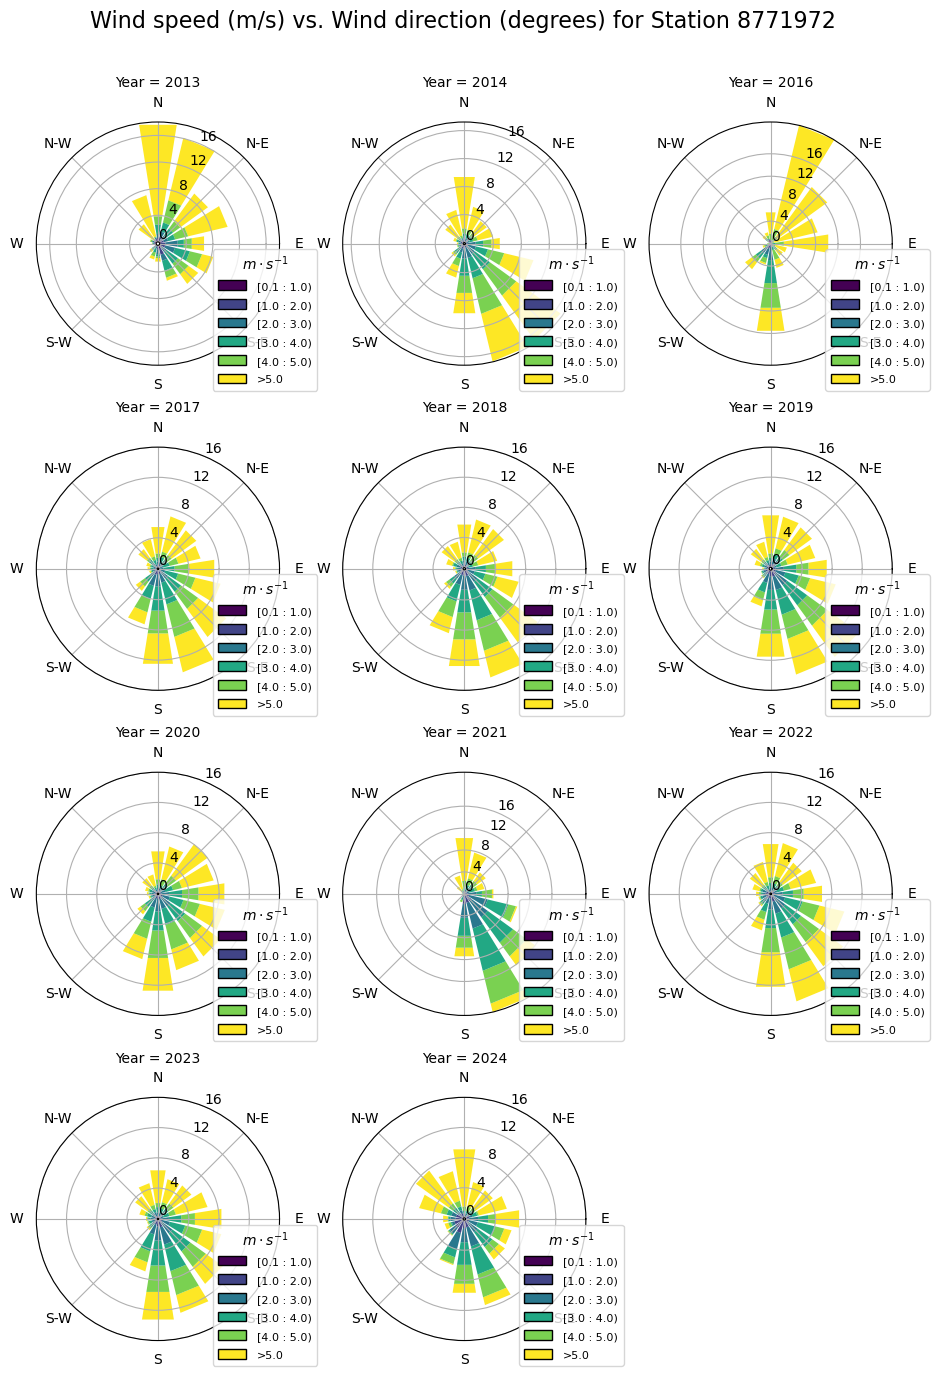

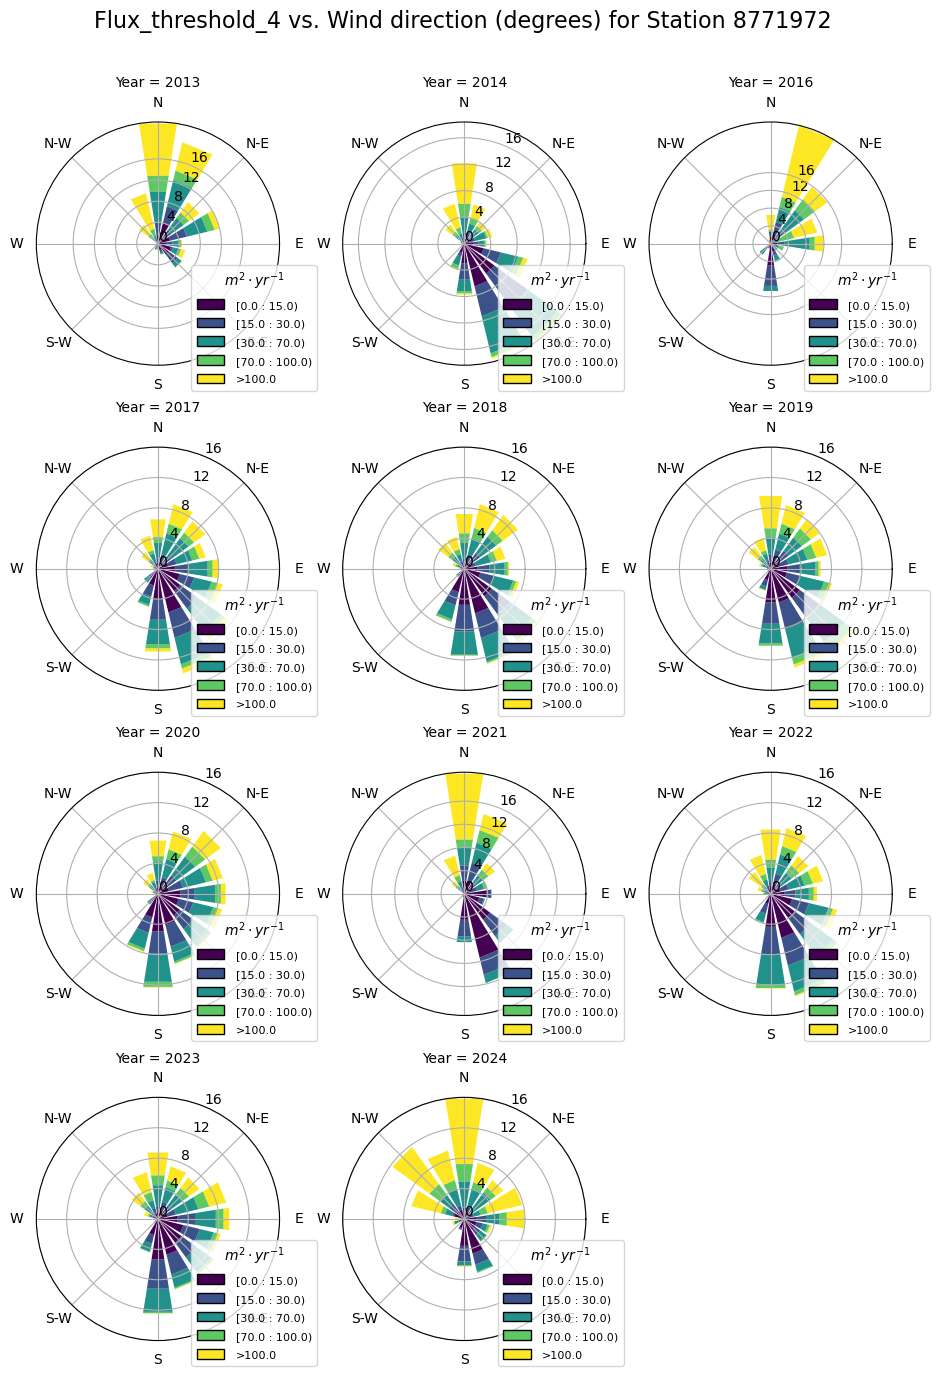

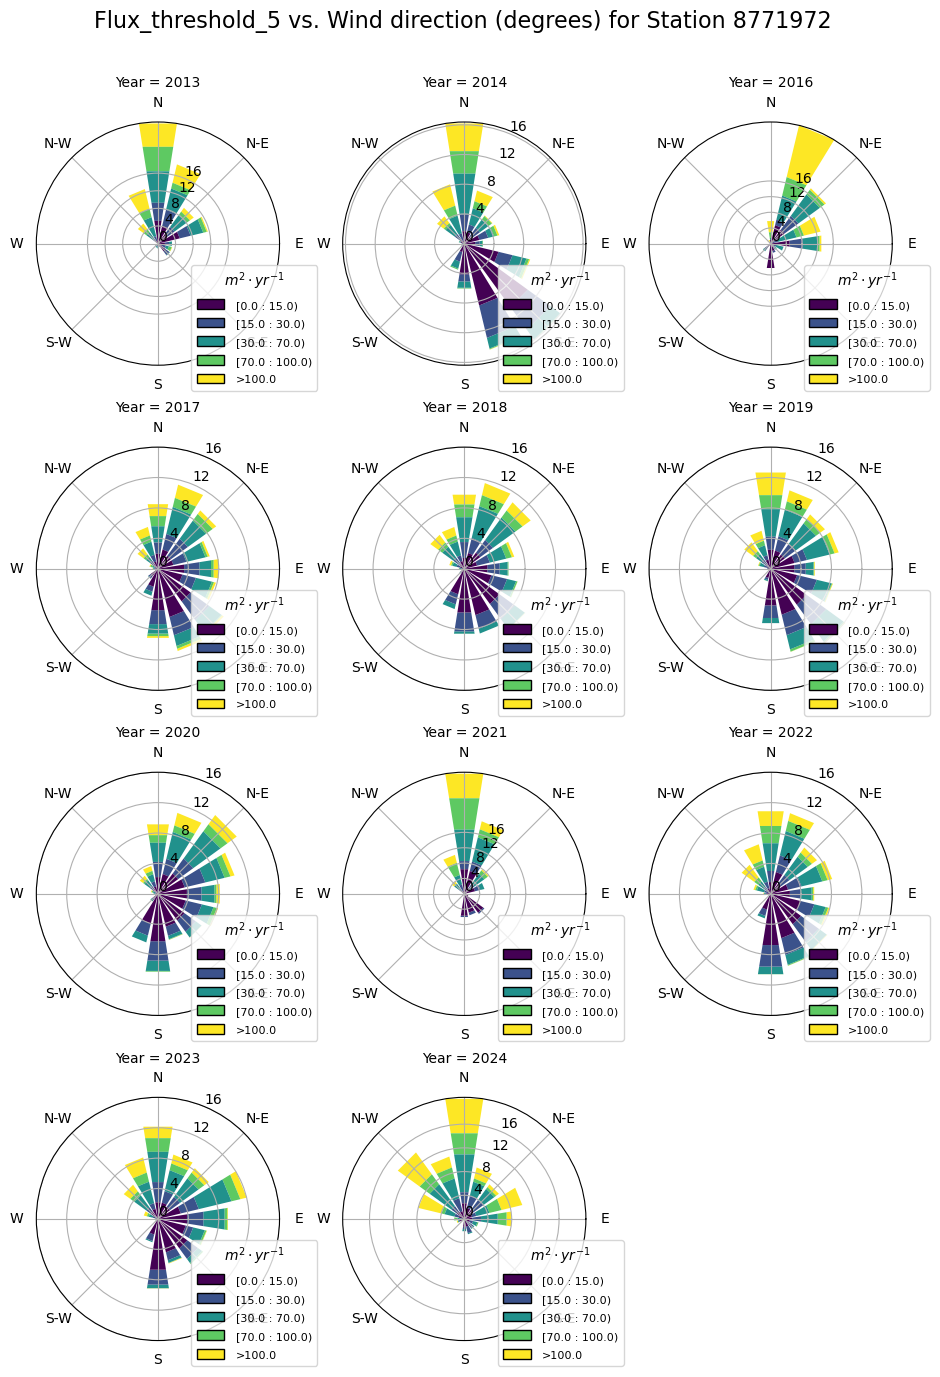

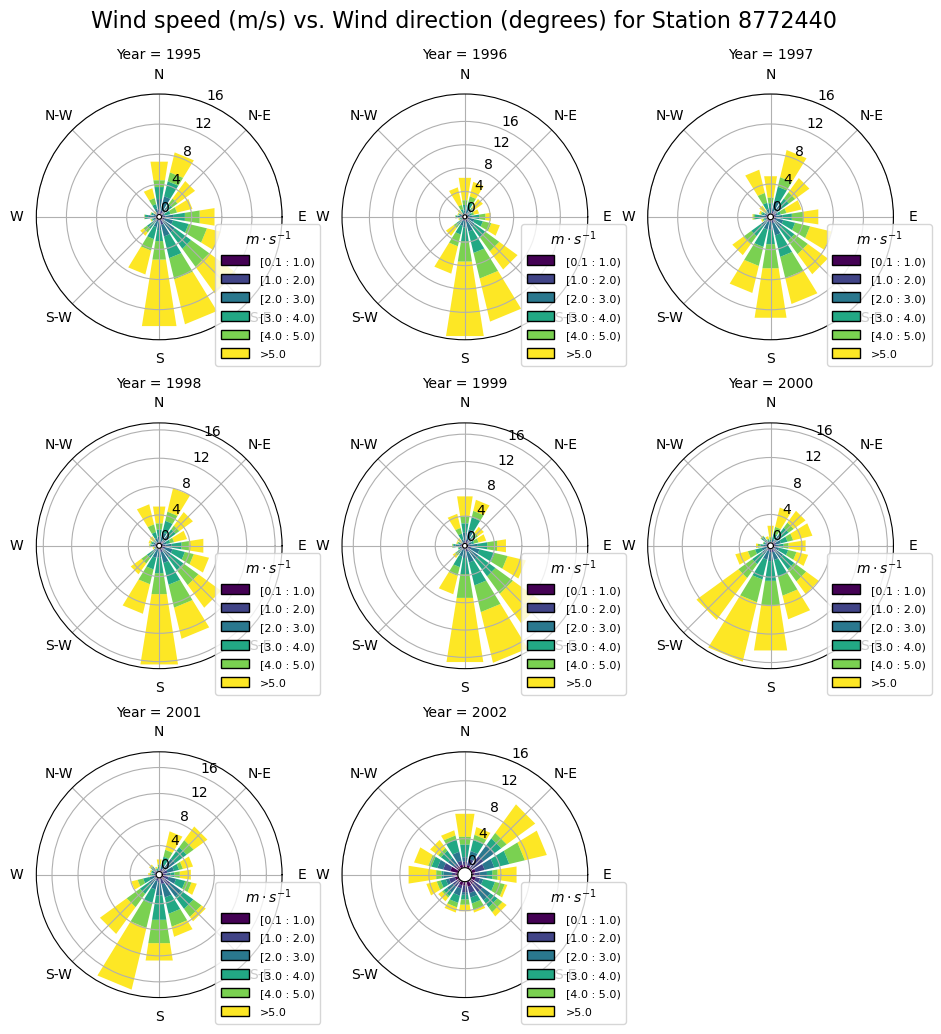

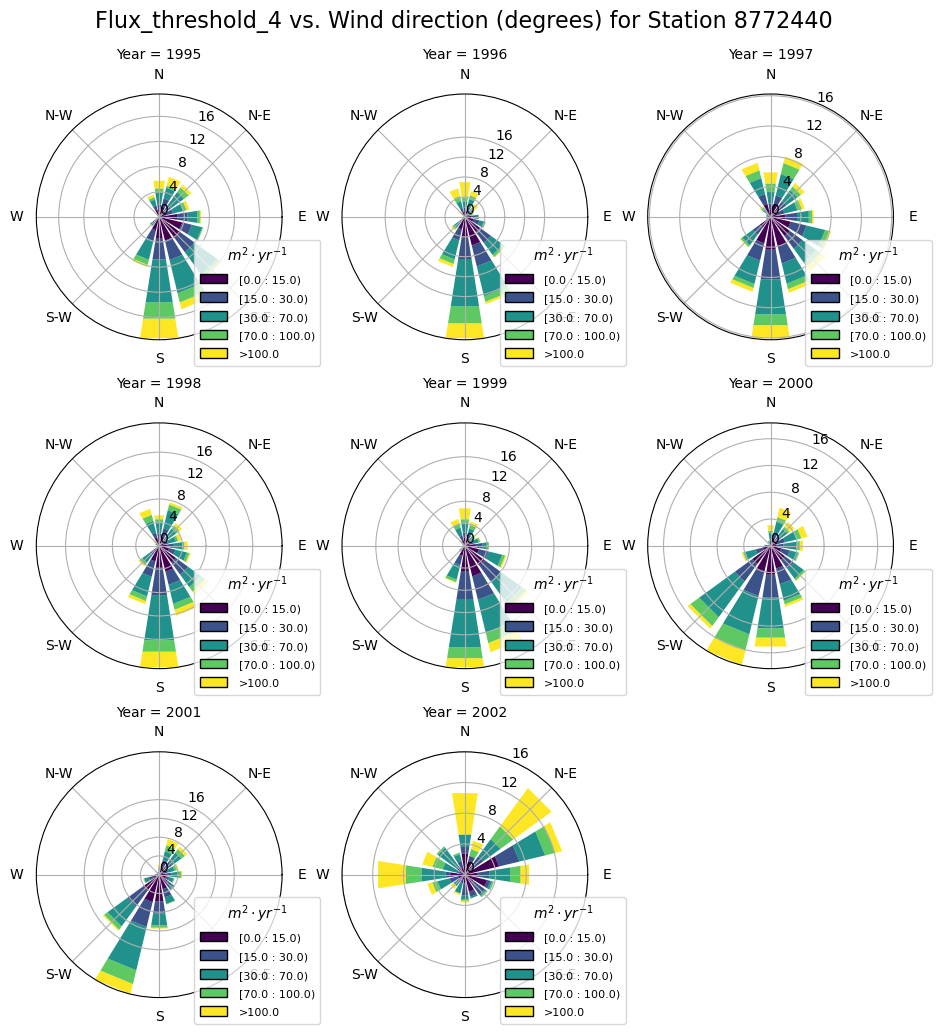

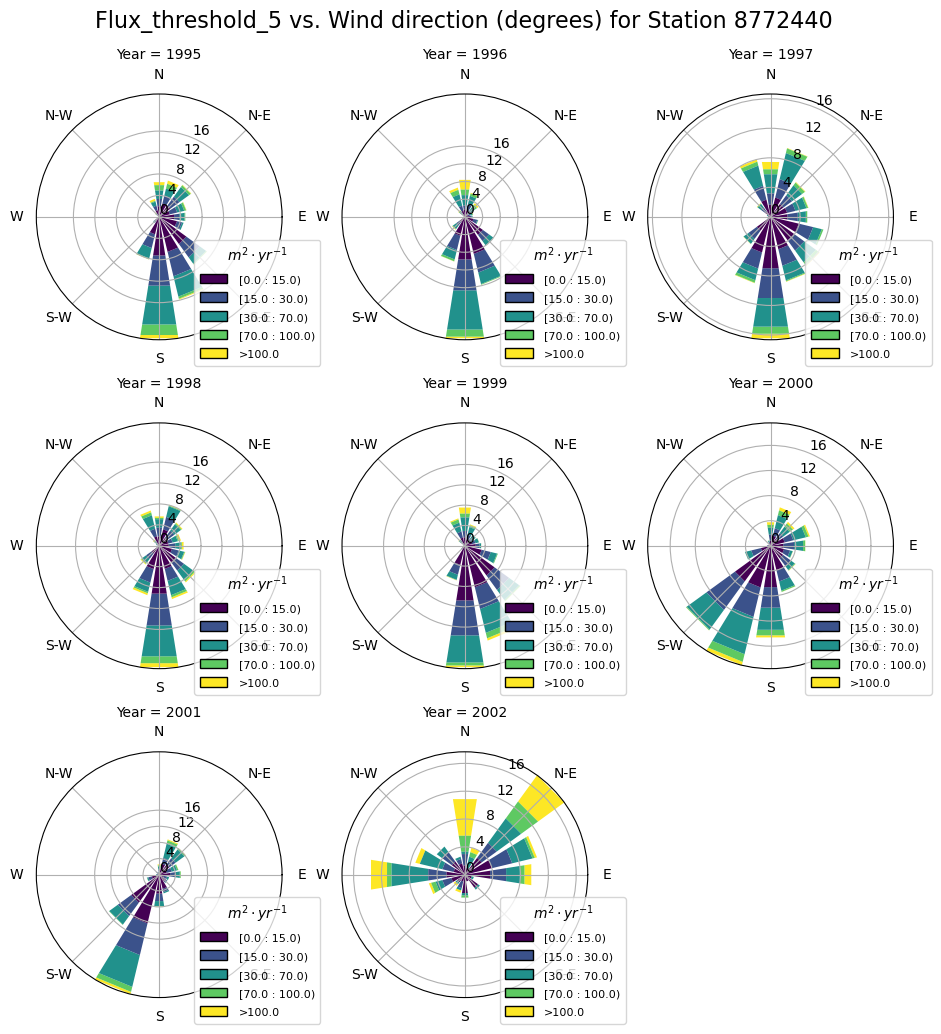

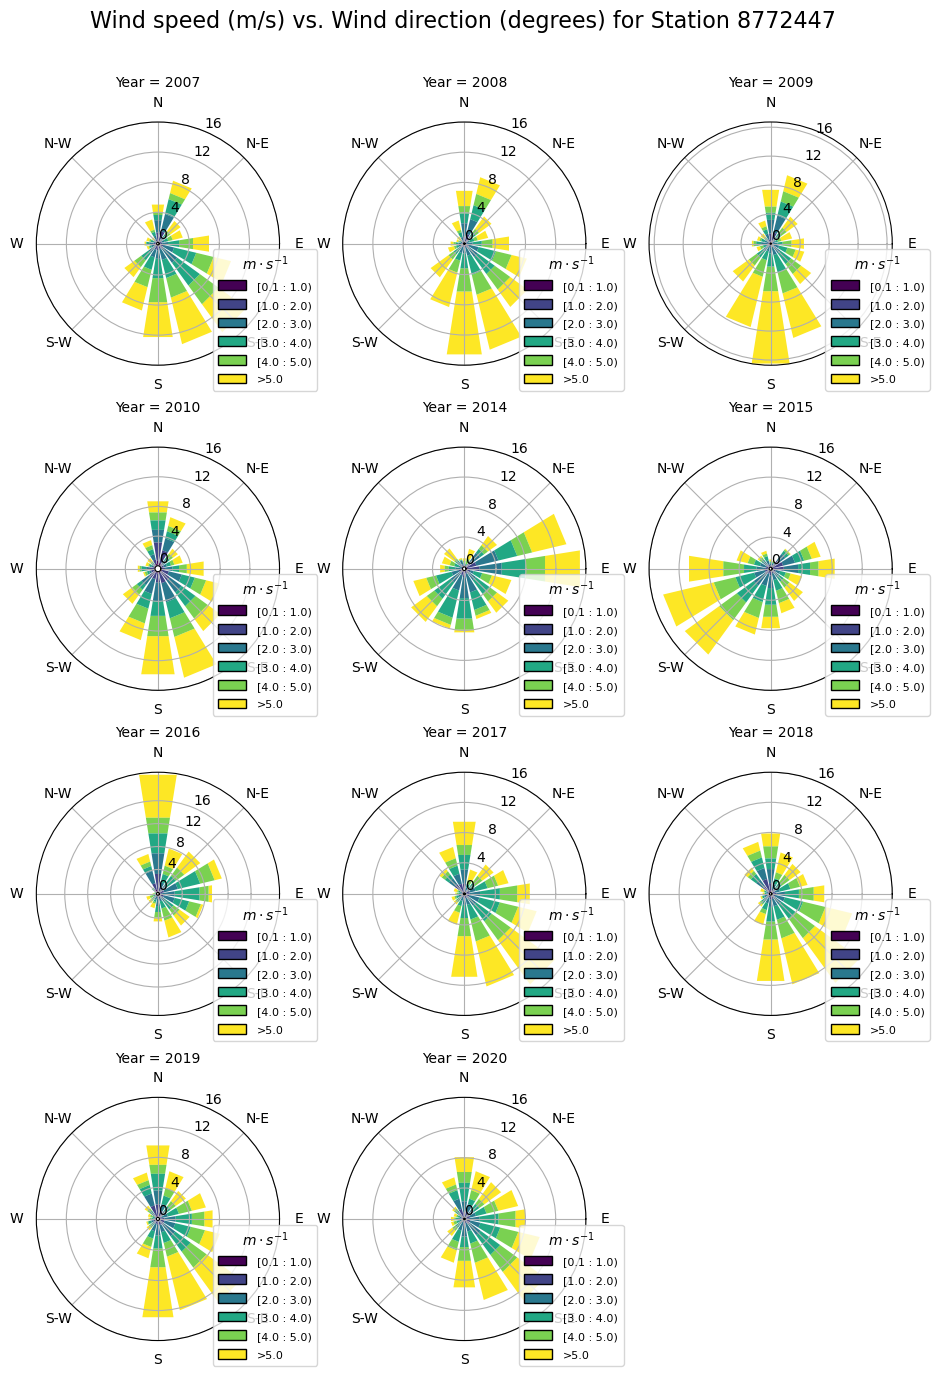

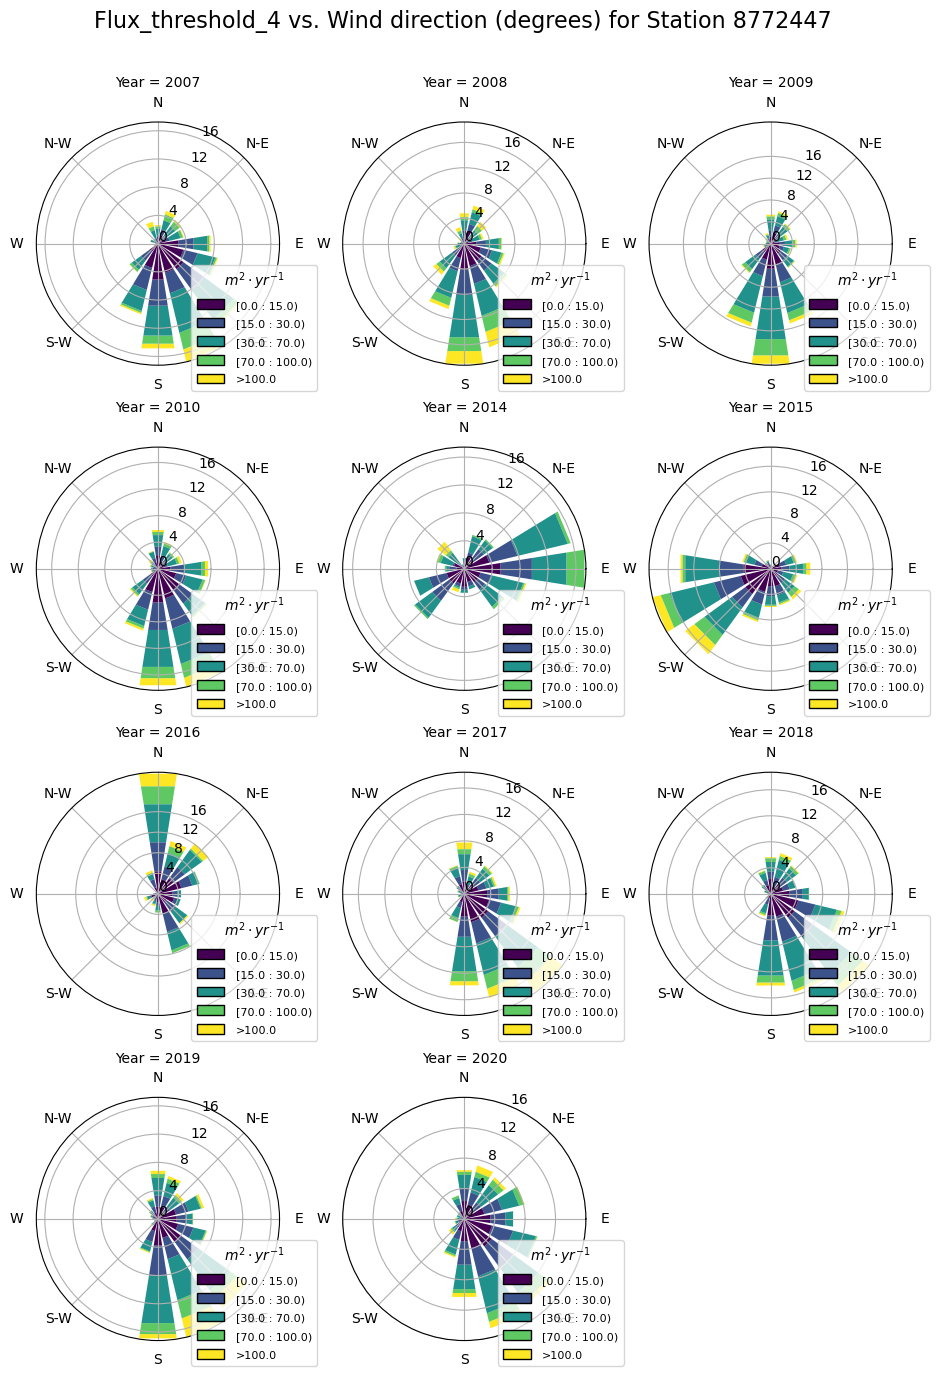

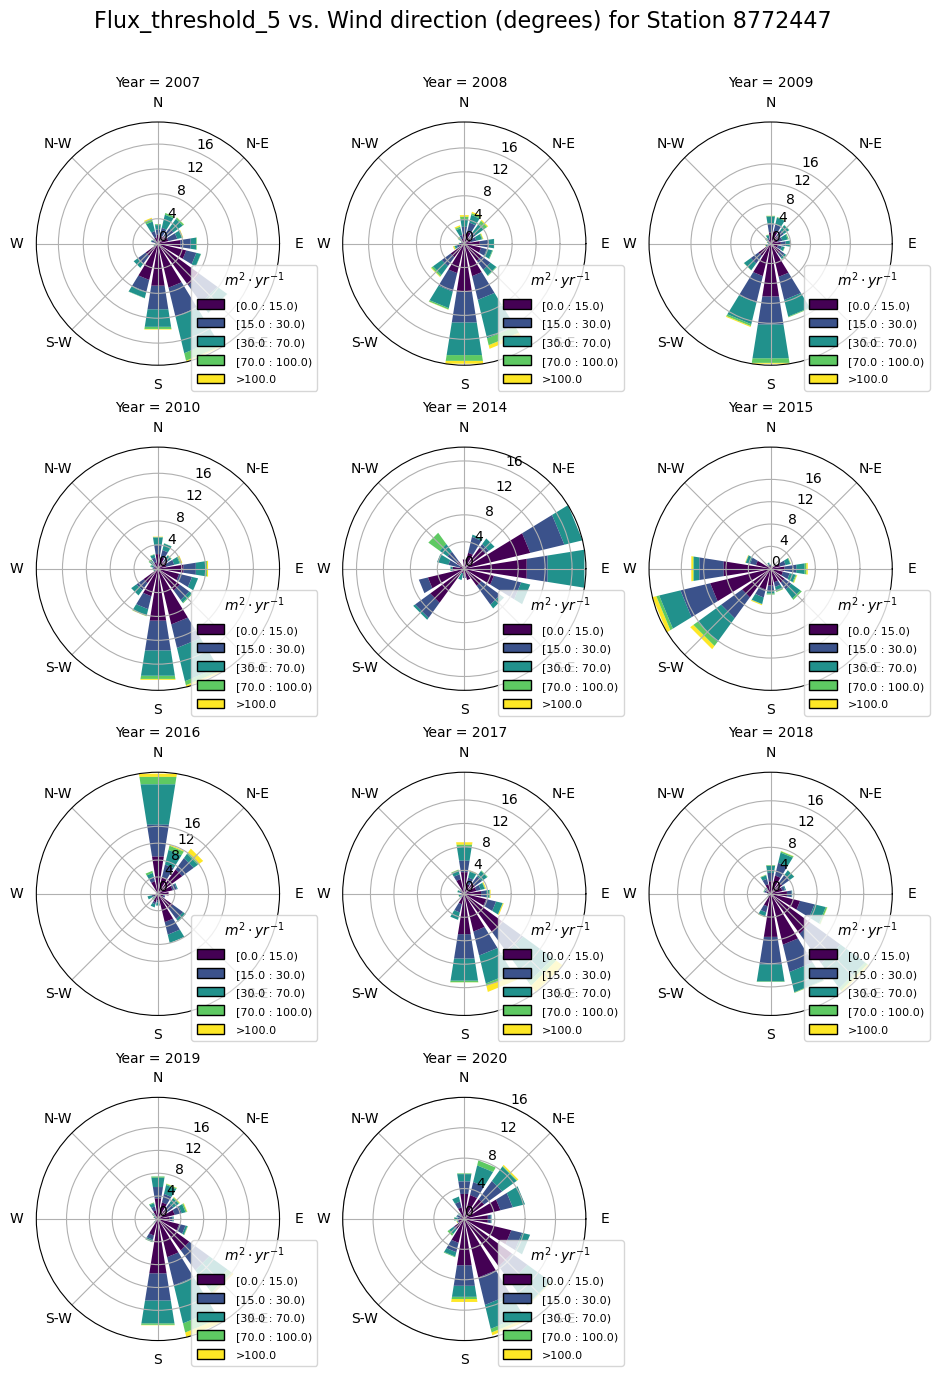

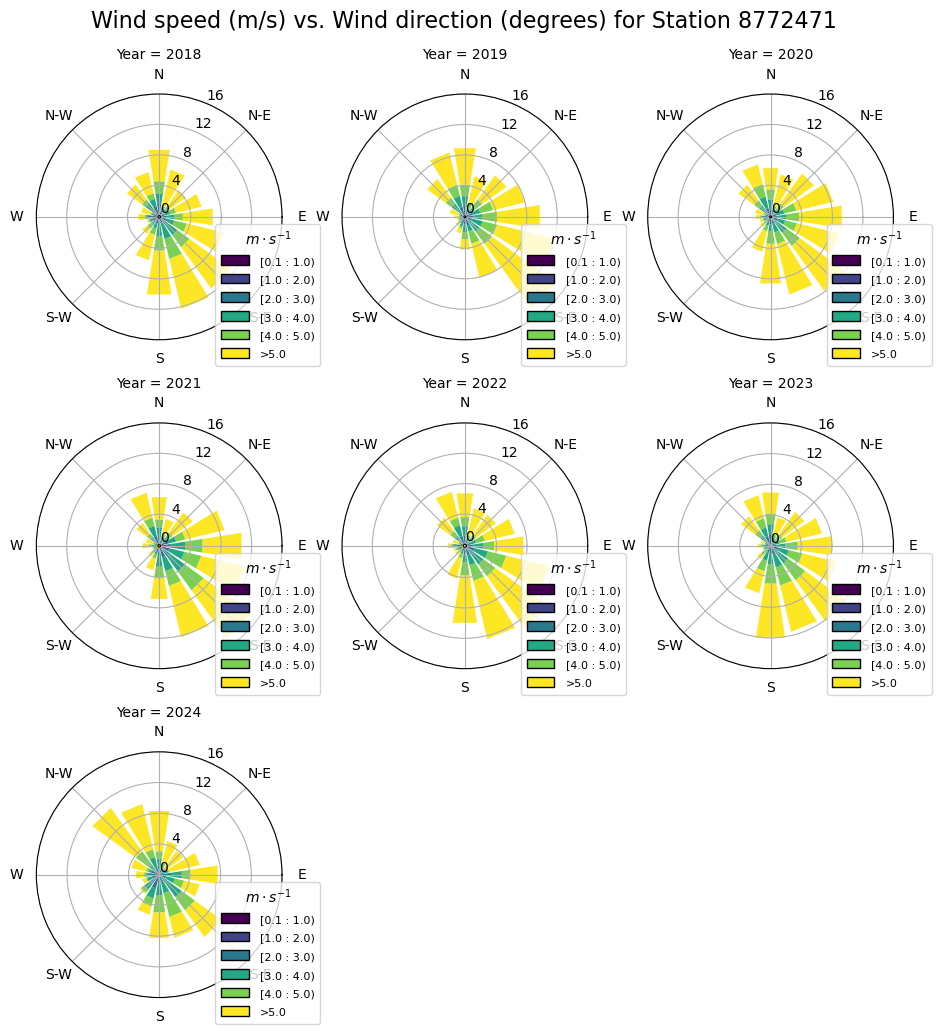

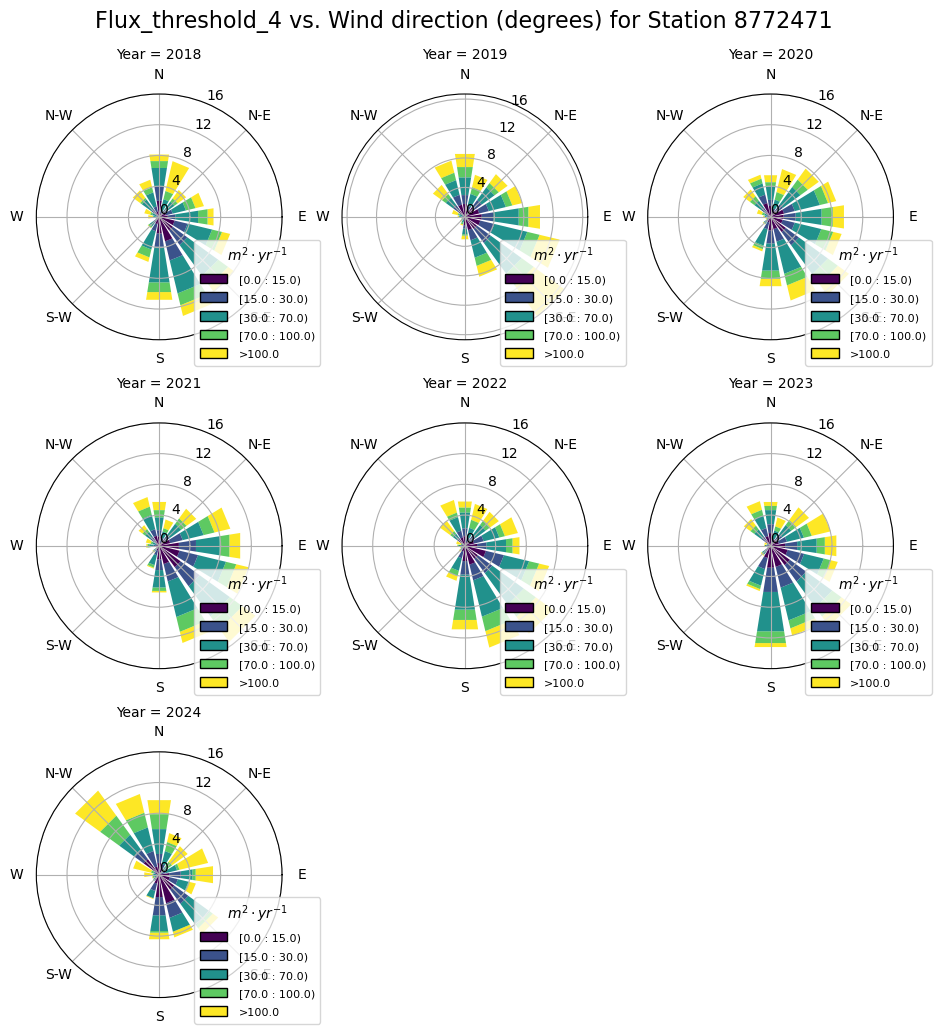

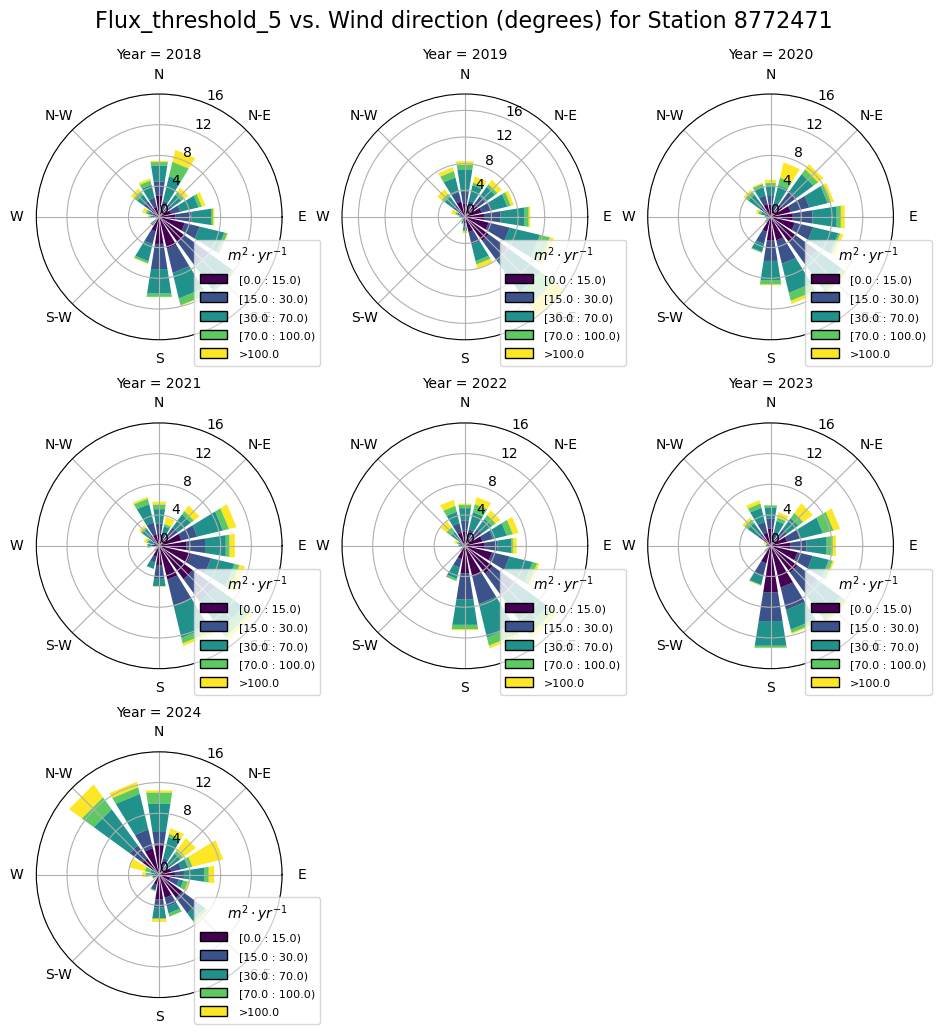

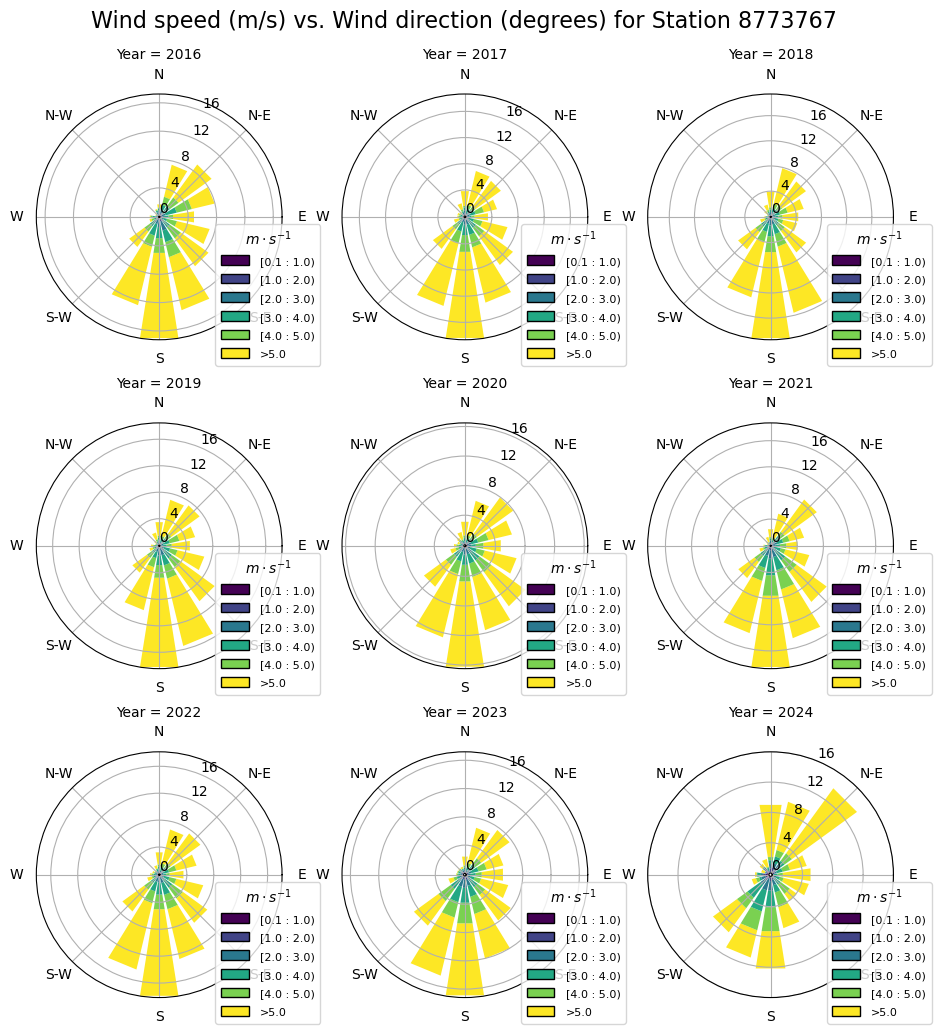

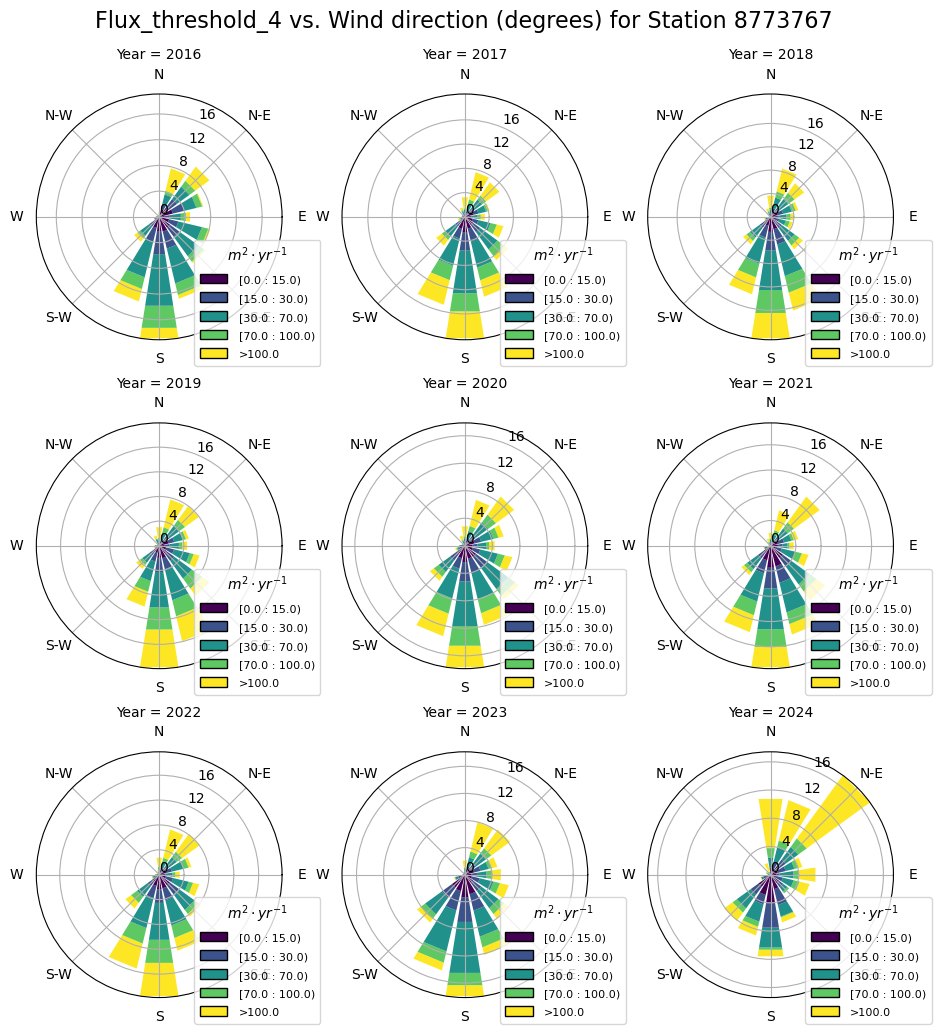

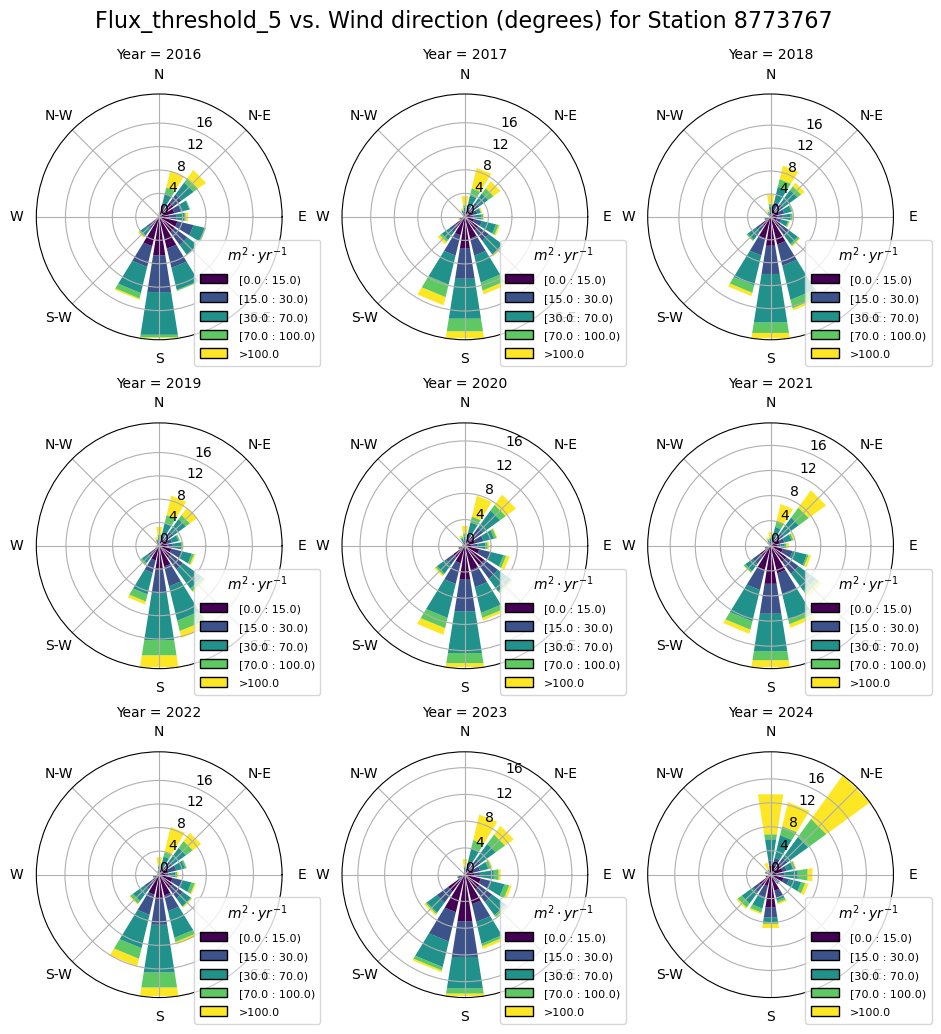

In [14]:
for dataset_name, df in datasets.items():
    for direction_column, magnitude_column in column_pairs:
        title = f"{magnitude_column.capitalize()} vs. {direction_column.capitalize()} for {dataset_name}"

        plot_windrose_facetgrid(
            df,
            direction_column=direction_column,
            magnitude_column=magnitude_column,
            title=title,
            base_path=base_path,
            subfolder=dataset_name,
        )